In [1]:
import wfdb
import os
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import FastICA
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML
# from google.colab import files
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.svm import SVC
import itertools
import warnings
np.warnings = warnings

# ここから

In [2]:
# ガウス関数定義
def gaussian_2d(coord, A, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coord #coord[:, 0], coord[:, 1]
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    return A * np.exp(-(a*(x - x0)**2 + 2*b*(x - x0)*(y - y0) + c*(y - y0)**2)) + offset

In [3]:
def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal, axis=0)), axis=0)

def ptp(signal):
    return np.ptp(signal, axis=0)

def arv(signal):
    return np.mean(np.abs(signal), axis=0)

def rms(signal):
    return np.sqrt(np.mean(signal**2, axis=0))

def zc(signal):
    s = np.sign(signal)
    s_prev = s[:-1]
    s_next = s[1:]
    sign_change = (s_prev * s_next) < 0
    return np.sum(sign_change, axis=0)

In [4]:
def ninety2ninety_radian(theta_radian):
  return (theta_radian + np.pi/2) % np.pi - np.pi/2

In [5]:
def get_centers_directions(emg_data, curve, feature_func, fs=2000, window_ms=25, threshold=0):
  # ---------- パラメータ設定 ----------
  emg_data = emg_data  # shape: (n_samples, n_channels)
  curve = curve  # 近似曲面
  feature_func = feature_func  # 特徴量抽出関数
  fs = fs  # サンプリング周波数
  window_ms = window_ms    # ウィンドウ幅 [ms]
  window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
  threshold = threshold   # featureの最大 - 平均がこの値以上なら採用
  half_win = window_size // 2

  # ---------- 出力先 ----------
  valid_indices = []

  # ---------- 64チャネルすべてに対してピーク検出 ----------
  peak_mask = np.zeros(emg_data.shape[0], dtype=bool)

  for ch in range(64):
      rms_signal = np.sqrt(emg_data[:,ch]**2)
      peaks, _ = find_peaks(rms_signal, distance=50,
                        height=np.mean(rms_signal) + np.std(rms_signal))
      # peaks, _ = find_peaks(emg_data[:, ch], distance=window_size//2, height=np.std(emg_data[:,ch]) * 1)
      peak_mask[peaks] = True  # どこか1チャネルでもピークがあればTrue

  # ---------- 全体でのピーク位置で条件を評価 ----------
  for t in np.where(peak_mask)[0]:
      if t - half_win < 0 or t + half_win >= emg_data.shape[0]:
          continue  # ウィンドウが境界を超えるならスキップ

      snippet = emg_data[t - half_win : t + half_win, :]  # shape: [window_size, 64]
      feature_per_ch = feature_func(snippet)  # 各チャネルのfeature
      feature_mean = np.mean(feature_per_ch)
      feature_max = np.max(feature_per_ch)

      if feature_max - feature_mean >= threshold:
          valid_indices.append(t)

  print(f"検出されたピーク数（条件を満たすもの）: {len(valid_indices)}")

  # ----- MUAP波形の切り出し -----
  snippets = []
  valid_peaks = []
  for peak in valid_indices:
      if peak - window_size//2 >= 0 and peak + window_size//2 < emg_data.shape[0]:
          snippet = emg_data[peak - window_size//2 : peak + window_size//2, :]
          snippets.append(snippet)
          valid_peaks.append(peak)

  snippets = np.array(snippets)
  valid_peaks = np.array(valid_peaks)


  # 座標グリッド
  x = np.arange(8)
  y = np.arange(8)
  xv, yv = np.meshgrid(x, y)
  coords = np.vstack((xv.ravel(), yv.ravel()))

  centers = []
  directions = []
  theta_1s = []
  features = []
  for snippet in snippets[:]:
    segment = snippet
    #ピーク間振幅
    feature = feature_func(segment) #shape:(64,)
    map_2d = feature.reshape(8, 8)

    # フィッティング
    max_index = np.unravel_index(np.argmax(map_2d), map_2d.shape)
    initial = [np.max(feature)-np.min(feature), max_index[0], max_index[1], 1, 1, 0, np.min(feature)]
    bounds = ([0, 0, 0, 0.1, 0.1, -np.pi/2, -np.inf],
            [np.inf, 7, 7, 5, 5, np.pi/2, np.inf])
    popt, _ = curve_fit(curve, coords, feature, p0=initial, bounds=bounds, maxfev=10000)
    A, x0, y0, sigma_x, sigma_y, theta, offset = popt #パラメータ取得
    center = (x0, y0)
    if sigma_x > sigma_y:
      theta_1 = ninety2ninety_radian(theta)
      # print('σx > σy')
    else:
      theta_1 = ninety2ninety_radian(theta + np.pi/2)
      # print('σy >= σx')
    direction = (np.cos(theta_1), np.sin(theta_1))

    centers.append(center)
    directions.append(direction)
    theta_1s.append(np.degrees(theta_1))

    feature = []
    feature.append(center[0])
    feature.append(center[1])
    feature.append(np.degrees(theta_1))
    features.append(feature)

  # print(centers)
  # print(directions)
  # print(theta_1s)
  # print(f'all centers:: ave:{np.mean(centers, axis=0)}, std:{np.std(centers, axis=0)}')
  # print(f'all theta_1:: ave:{np.mean(theta_1s, axis=0)}, std:{np.std(theta_1s, axis=0)}')

  return features

In [21]:
def clustering(features, k1=4, k2=3):
    # 1. 特徴ベクトルを構築
    features = np.array(features)
    results_df = pd.DataFrame(data=features, columns=['center_x', 'center_y', 'theta_deg'])

    # --- 第1段階：中心座標でクラスタリング ---
    # 特徴量：center_x, center_y
    center_features = results_df[['center_x', 'center_y']].dropna()
    k1 = k1  # 中心クラスタ数（例）
    kmeans1 = KMeans(n_clusters=k1, random_state=0)
    center_labels = kmeans1.fit_predict(center_features)

    # 結果に追加
    results_df['center_cluster'] = -1
    results_df.loc[center_features.index, 'center_cluster'] = center_labels

    # # --- 第2段階：方向角でクラスタリング（各中心クラスタ内で） ---
    # # θの周期性を考慮 → sinθ, cosθでクラスタリング
    # results_df['theta_sin'] = np.sin(results_df['theta_rad'])
    # results_df['theta_cos'] = np.cos(results_df['theta_rad'])

    direction_cluster_labels = np.full(len(results_df), -1)  # 初期化

    k2 = k2  # 各中心クラスタ内の方向クラスタ数（例）

    for group_id in range(k1):
        group_df = results_df[results_df['center_cluster'] == group_id]
        idx = group_df.index
        if len(group_df) >= k2:  # クラスタ数以上あるか確認
            dir_features = group_df[['theta_deg']].values
            kmeans2 = KMeans(n_clusters=k2, random_state=0)  # 固定乱数
            sub_labels = kmeans2.fit_predict(dir_features)
            direction_cluster_labels[idx] = sub_labels + group_id * 10  # 固有ラベル化

    # 結果に追加
    results_df['direction_cluster'] = direction_cluster_labels


    # クラスタごとに平均・標準偏差を集計
    cluster_stats = results_df.groupby('direction_cluster').agg({
        'center_x': ['mean', 'std'],
        'center_y': ['mean', 'std'],
        'theta_deg': ['mean', 'std'],
        'direction_cluster': 'count'
    })

    # 結果をまとめ直す
    summary_df = pd.DataFrame({
        'cluster': cluster_stats.index,
        'center_x_mean': cluster_stats[('center_x', 'mean')],
        'center_x_std': cluster_stats[('center_x', 'std')],
        'center_y_mean': cluster_stats[('center_y', 'mean')],
        'center_y_std': cluster_stats[('center_y', 'std')],
        'theta_deg_mean': cluster_stats[('theta_deg', 'mean')],
        'theta_deg_std': cluster_stats[('theta_deg', 'std')],
        # 'count': results_df['cluster'].value_counts().sort_index(),
        'count': cluster_stats[('direction_cluster', 'count')]
    }).reset_index(drop=True)

    # 結果表示
    summary_df

    return results_df, summary_df

In [ ]:
# # 角度の修正版
# def clustering(features, k1=4, k2=3):
#     # 1. 特徴ベクトルを構築
#     features = np.array(features)
#     results_df = pd.DataFrame(data=features, columns=['center_x', 'center_y', 'theta_deg'])

#     # --- 第1段階：中心座標でクラスタリング ---
#     # 特徴量：center_x, center_y
#     center_features = results_df[['center_x', 'center_y']].dropna()
#     k1 = k1  # 中心クラスタ数（例）
#     kmeans1 = KMeans(n_clusters=k1, random_state=0)
#     center_labels = kmeans1.fit_predict(center_features)

#     # 結果に追加
#     results_df['center_cluster'] = -1
#     results_df.loc[center_features.index, 'center_cluster'] = center_labels

#     # # --- 第2段階：方向角でクラスタリング（各中心クラスタ内で） ---
#     # # θの周期性を考慮 → sinθ, cosθでクラスタリング
#     # results_df['theta_sin'] = np.sin(results_df['theta_rad'])
#     # results_df['theta_cos'] = np.cos(results_df['theta_rad'])

#     direction_cluster_labels = np.full(len(results_df), -1)  # 初期化

#     k2 = k2  # 各中心クラスタ内の方向クラスタ数（例）

#     for group_id in range(k1):
#         group_df = results_df[results_df['center_cluster'] == group_id]
#         idx = group_df.index
#         if len(group_df) >= k2:  # クラスタ数以上あるか確認
#             cos = np.cos(np.radians(2*group_df[['theta_deg']].values))
#             sin = np.sin(np.radians(2*group_df[['theta_deg']].values))
#             dir_features = np.column_stack((cos, sin))
#             kmeans2 = KMeans(n_clusters=k2, random_state=0)  # 固定乱数
#             sub_labels = kmeans2.fit_predict(dir_features)
#             direction_cluster_labels[idx] = sub_labels + group_id * 10  # 固有ラベル化

#     # 結果に追加
#     results_df['direction_cluster'] = direction_cluster_labels


#     # クラスタごとに平均・標準偏差を集計
#     cluster_stats = results_df.groupby('direction_cluster').agg({
#         'center_x': ['mean', 'std'],
#         'center_y': ['mean', 'std'],
#         'theta_deg': ['mean', 'std'],
#         'direction_cluster': 'count'
#     })

#     # 結果をまとめ直す
#     summary_df = pd.DataFrame({
#         'cluster': cluster_stats.index,
#         'center_x_mean': cluster_stats[('center_x', 'mean')],
#         'center_x_std': cluster_stats[('center_x', 'std')],
#         'center_y_mean': cluster_stats[('center_y', 'mean')],
#         'center_y_std': cluster_stats[('center_y', 'std')],
#         'theta_deg_mean': cluster_stats[('theta_deg', 'mean')],
#         'theta_deg_std': cluster_stats[('theta_deg', 'std')],
#         # 'count': results_df['cluster'].value_counts().sort_index(),
#         'count': cluster_stats[('direction_cluster', 'count')]
#     }).reset_index(drop=True)

#     # 結果表示
#     summary_df

#     return results_df, summary_df

In [8]:
def get_cluster_colors(n_clusters, cmap_name='tab20'):
    cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.
    return [cmap(i) for i in range(n_clusters)]

In [9]:
def plot_fiber(results_df, arrow_scale=0.5, show_arrow=True):
  arrow_scale = arrow_scale

  n_clusters = results_df['direction_cluster'].nunique()
  cluster_colors = get_cluster_colors(n_clusters)

  # プロット準備
  plt.figure(figsize=(7, 6))
  for n, center_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == center_cluster]
    color = cluster_colors[n]

    for _, row in sub_df.iterrows():
          x, y = row['center_x'], row['center_y']
          theta = row['theta_deg']
          dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale

          # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
          if show_arrow:
            plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
          plt.plot(x, y, 'o', color=color,
                  label=f"Center Cl {center_cluster}" if f"Center Cl {center_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")

  # ラベル・軸
  plt.xlabel("x")
  plt.ylabel("y")
  # plt.title("2-Stage Clustering of Muscle Fiber Direction")
  plt.grid(True)
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.axis('equal')
  plt.tight_layout()
  plt.xticks(np.arange(0, 8, 1))
  plt.yticks(np.arange(0, 8, 1))
  plt.xlim(0, 7)
  plt.ylim(0, 7)
  plt.show()

In [ ]:
def get_virtual_bipolars(results_df, ied=2, arrow_scale=0.5, show_plot=True):
  #仮想双極電極の電極間距離（cm）
  a = ied

  if show_plot:
    n_clusters = results_df['direction_cluster'].nunique() #
    cluster_colors = get_cluster_colors(n_clusters) #

  virtual_bipolars = []
  labels = []
  center_direction = []
  n_virtual_bipolars_checker = []
  if show_plot:
    plt.figure(figsize=(7, 6)) #
  for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
    # if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
    x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
    theta = sub_df['theta_deg'].mean()
    dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale #
    # print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
    x1 = x - a/2*np.cos(np.radians(theta))
    y1 = y - a/2*np.sin(np.radians(theta))
    x2 = x + a/2*np.cos(np.radians(theta))
    y2 = y + a/2*np.sin(np.radians(theta))
    virtual_bipolars.append([x1, y1, x2, y2])
    labels.append(direction_cluster)
    center_direction.append([x, y, theta])
    n_virtual_bipolars_checker.append(True)
    if show_plot:
      # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
      color = cluster_colors[n]
      plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
      plt.plot(x, y, 'o', color=color,
                label=f"Center Cl {direction_cluster}" if f"Center Cl {direction_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")
  # if len(n_virtual_bipolars_checker) == 1:
  #   virtual_bipolars.append([0,0,0,0])
  #   labels.append(999)
  #   center_direction.append([0,0,0])
  if show_plot:
    # ラベル・軸
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.title("2-Stage Clustering of Muscle Fiber Direction")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.axis('equal')
    plt.tight_layout()
    plt.xticks(np.arange(0, 8, 1))
    plt.yticks(np.arange(0, 8, 1))
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    plt.show()

  return virtual_bipolars, labels, center_direction, len(n_virtual_bipolars_checker)

In [11]:
def extract_rms_features(windows):
    """
    各ウィンドウからチャネルごとのRMS特徴量を抽出
    入力: shape = (window_size, n_channels)
    出力: shape = (n_channels)
    """
    return np.sqrt(np.mean(np.square(windows), axis=0))

In [12]:
def get_virtual_emg(emg_data, virtual_bipolars):
  # --- データ読み込み ---
  emg_data = emg_data

  # === スライディングウィンドウ抽出 ===
  n_samples = emg_data.shape[0]
  segments = []
  time_stamps = []

  # 座標グリッド
  x = np.arange(8)
  y = np.arange(8)
  xv, yv = np.meshgrid(x, y)
  coords = np.vstack((xv.ravel(), yv.ravel()))
  # # パラメータ計算
  # f = RectBivariateSpline(x, y, map_2d)

  virtual_emg = []
  for i in range(n_samples):
    f = RectBivariateSpline(x, y, emg_data[i].reshape(8,8))
    z_list = []
    for bipolar in virtual_bipolars:
      x1=bipolar[0]
      y1=bipolar[1]
      x2=bipolar[2]
      y2=bipolar[3]
      z1 = f(x1, y1)
      z2 = f(x2, y2)
      z_diff = z1 - z2
      z_list.append(z_diff)
    virtual_emg.append(np.array(z_list).reshape(-1))
  virtual_emg = np.array(virtual_emg)

  # print(emg_data.shape)
  # print(virtual_emg.shape)

  return virtual_emg

In [13]:
def get_features(virtual_emg, labels, fs=2000, window_ms=50, stride_ms=20):
  # --- データ読み込み例（ここではダミーデータ） ---
  fs = fs  # サンプリング周波数
  window_ms = window_ms    # ウィンドウ幅 [ms]
  stride_ms = stride_ms    # スライド幅 [ms]
  window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
  stride_size = int(fs * stride_ms / 1000)  # スライド数
  n_samples = virtual_emg.shape[0]
  X = []
  y = []
  for start in range(0, n_samples - window_size + 1, stride_size):
      end = start + window_size
      window_emg = virtual_emg[start:end, :]
      #特徴量抽出
      rms = extract_rms_features(window_emg) # shape: (virtual_bipolar_channels,)
      X.append(rms)
      y.append(labels)
  return X, y

In [14]:
#分類器
def SVC_classifier(X_session1, y_session1, X_session2, y_session2):

    X_train = np.array(X_session1).reshape(-1,1)
    y_train = np.array(y_session1).reshape(-1,1)
    X_test = np.array(X_session2).reshape(-1,1)
    y_test = np.array(y_session2).reshape(-1,1)

    # データ分割
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # SVMモデル学習
    model = SVC(kernel='rbf', probability=True, random_state=0)
    model.fit(X_train, y_train)

    prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
    # === 各テストラベルごとに学習クラスへの平均確率を出力 ===
    class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

    result = []

    for test_label in np.unique(y_test):
        idx = y_test.reshape(-1) == test_label
        mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
        result.append([test_label] + list(mean_prob))

    # # === 表形式で表示 ===
    # columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
    # df_result = pd.DataFrame(result, columns=columns)
    # print(df_result)
    
    return result, y_train, y_test

In [15]:
def calc_diff(train_idx, test_idx, center_direction_session1, center_direction_session2):
    center_direction_session1 = center_direction_session1
    center_direction_session2 = center_direction_session2
    #計算
    center_x_train = np.array(center_direction_session1)[train_idx, 0]
    center_y_train = np.array(center_direction_session1)[train_idx, 1]
    theta_train = np.array(center_direction_session1)[train_idx, 2]
    center_x_test = np.array(center_direction_session2)[test_idx, 0]
    center_y_test = np.array(center_direction_session2)[test_idx, 1]
    theta_test = np.array(center_direction_session2)[test_idx, 2]
    center_x_diff = center_x_train - center_x_test
    center_y_diff = center_y_train - center_y_test
    theta_diff = theta_train - theta_test
    return center_x_diff, center_y_diff, theta_diff

In [16]:
def diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2):
  max_train_idx = []
  for i in range(np.array(result).shape[0]):
    j = np.argmax(np.array(result)[i,1:])
    max_train_idx.append(j)
  # print(max_train_idx)
  diff =[]
  for k in set(max_train_idx):
    if max_train_idx.count(k) >=2:
      idx = max_train_idx == k
      l = np.argmax(np.array(result)[idx, k+1], axis=0)
      max_test_idx = [i for i, j in enumerate(idx) if j == True]
      # print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_test_idx[l]], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})
    else:
      # print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_train_idx.index(k)], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})

  return diff

# 分析

In [11]:
record_session1 = wfdb.rdrecord('pr_dataset/subject01_session1/maintenance_raw_sample1')
record_session2 = wfdb.rdrecord('pr_dataset/subject01_session1/maintenance_preprocess_sample1')

In [12]:
filtered_emg_ED_session1 = record_session1.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session1 = record_session1.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session1 = record_session1.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session1 = record_session1.p_signal[:,192:256] #Flexor Proximal

filtered_emg_ED_session2 = record_session2.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session2 = record_session2.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session2 = record_session2.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session2 = record_session2.p_signal[:,192:256] #Flexor Proximal

emg_data shape: (8192, 64), y_fft shape: (8192, 64), freq shape: (8192,), magnitude shape: (8192, 64)


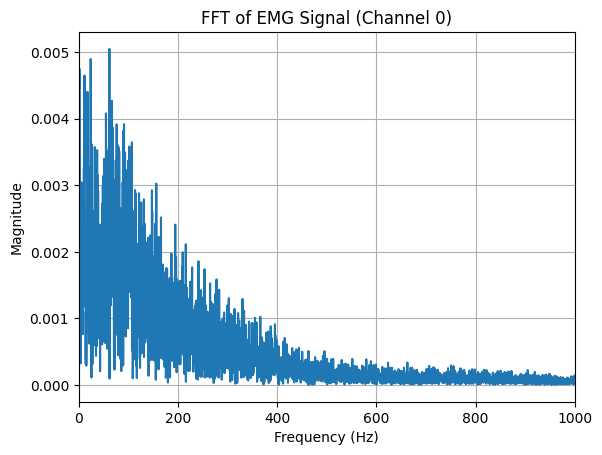

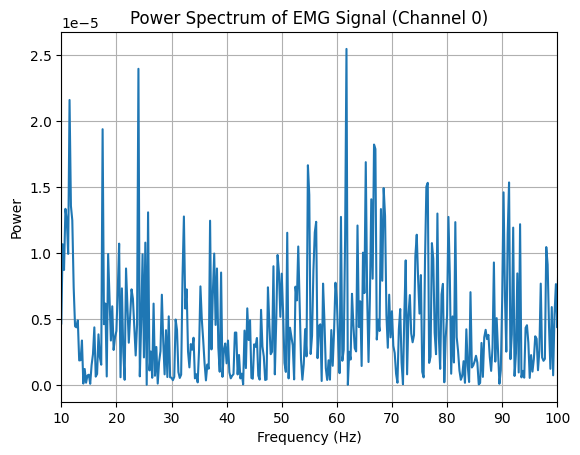

In [29]:
emg_data = filtered_emg_FD_session1
fs = 2048
n_samples = emg_data.shape[0]
dt = 1/fs
time = np.arange(0, n_samples*dt, dt)
y_fft = np.fft.fft(emg_data, axis=0)
freq = np.fft.fftfreq(n_samples, dt)
magnitude = np.abs(y_fft/(n_samples/2))
print(f'emg_data shape: {emg_data.shape}, y_fft shape: {y_fft.shape}, freq shape: {freq.shape}, magnitude shape: {magnitude.shape}')
plt.plot(freq[1:n_samples//2], magnitude[1:n_samples//2,0])
plt.xlim(0, 1000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of EMG Signal (Channel 0)')
plt.grid()
plt.show()

power = magnitude**2
plt.plot(freq[1:n_samples//2], power[1:n_samples//2,0])
plt.xlim(10, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum of EMG Signal (Channel 0)')
plt.grid()
plt.show()

In [24]:
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, cheb2ord, cheby2, firwin

def _ensure_2d(x: np.ndarray) -> tuple[np.ndarray, bool]:
    """(n_samples, n_channels) に整形して処理し、元形状を覚えて戻す。"""
    x = np.asarray(x)
    was_1d = False
    if x.ndim == 1:
        x = x[:, None]
        was_1d = True
    elif x.ndim != 2:
        raise ValueError("Input must be 1D or 2D array (samples[, channels]).")
    return x, was_1d

def band_edges_safe(low_hz: float, high_hz: float, fs: float, margin: float = 0.01) -> tuple[float,float]:
    """Nyquist超えや非正を避けて安全なカットオフに丸める。"""
    nyq = fs * 0.5
    low = max(0.0, float(low_hz))
    high = min(float(high_hz), nyq*(1.0 - margin))
    if not (0.0 < low < high < nyq):
        raise ValueError(f"Invalid band: low={low_hz}, high={high_hz}, fs={fs}")
    return low, high

# ------------------------------
# 1) Butterworth（0位相filtfilt）推奨
# ------------------------------
def butter_bandpass_filter(x, fs: float, low_hz: float, high_hz: float, order: int = 4):
    """
    ゼロ位相IIRバンドパス。EMGの一般処理に無難。
    x: 1D (n,) または 2D (n, ch)
    """
    low, high = band_edges_safe(low_hz, high_hz, fs)
    sos = butter(order, [low, high], btype='band', fs=fs, output='sos')
    x2, was_1d = _ensure_2d(x)
    y = sosfiltfilt(sos, x2, axis=0)
    return y.ravel() if was_1d else y

In [ ]:
fs = 2048                      # 例: 2 kHz
low_hz, high_hz = 20.0, 400.0    # 先に決めた帯域（状況に応じて調整）

x = emg_data

# 2) バンドパス（Butterworth）
x_bp = butter_bandpass_filter(x, fs, low_hz, high_hz, order=4)

emg_data shape: (8192, 64), y_fft shape: (8192, 64), freq shape: (8192,), magnitude shape: (8192, 64)


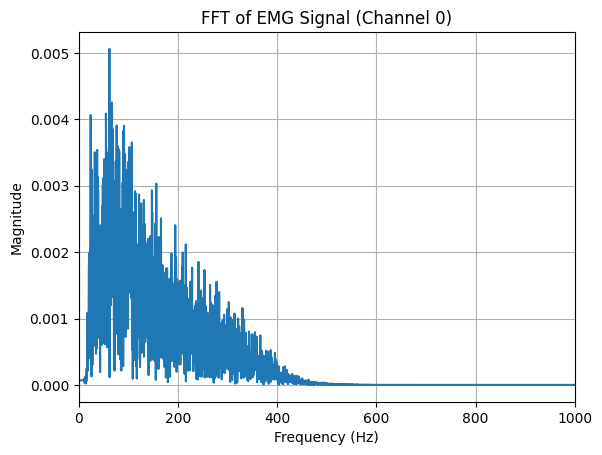

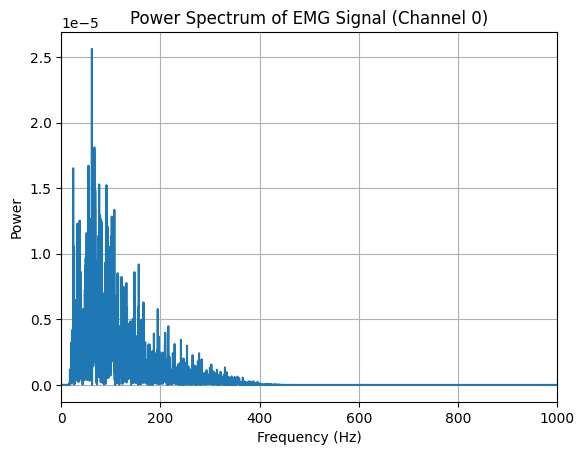

In [26]:
emg_data = x_bp
fs = 2048
n_samples = emg_data.shape[0]
dt = 1/fs
time = np.arange(0, n_samples*dt, dt)
y_fft = np.fft.fft(emg_data, axis=0)
freq = np.fft.fftfreq(n_samples, dt)
magnitude = np.abs(y_fft/(n_samples/2))
print(f'emg_data shape: {emg_data.shape}, y_fft shape: {y_fft.shape}, freq shape: {freq.shape}, magnitude shape: {magnitude.shape}')
plt.plot(freq[1:n_samples//2], magnitude[1:n_samples//2,0])
plt.xlim(0, 1000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of EMG Signal (Channel 0)')
plt.grid()
plt.show()

power = magnitude**2
plt.plot(freq[1:n_samples//2], power[1:n_samples//2,0])
plt.xlim(0, 1000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum of EMG Signal (Channel 0)')
plt.grid()
plt.show()

検出されたピーク数（条件を満たすもの）: 912


C:\Users\takeu\AppData\Local\Temp\ipykernel_19204\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


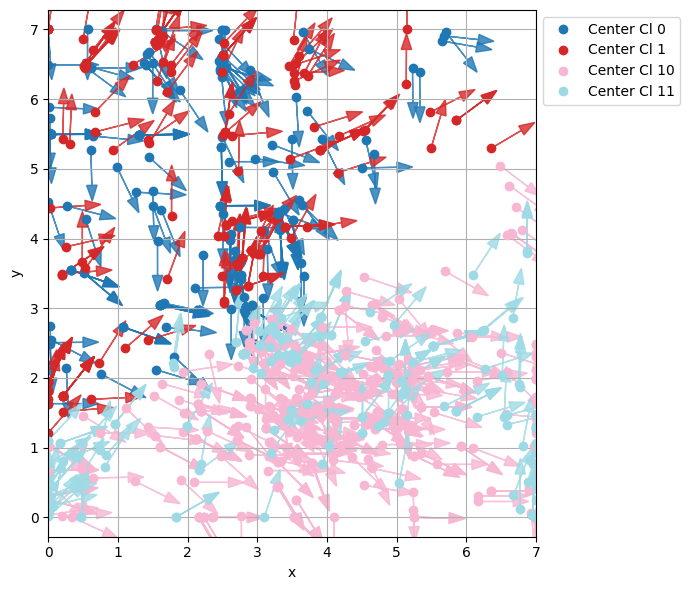

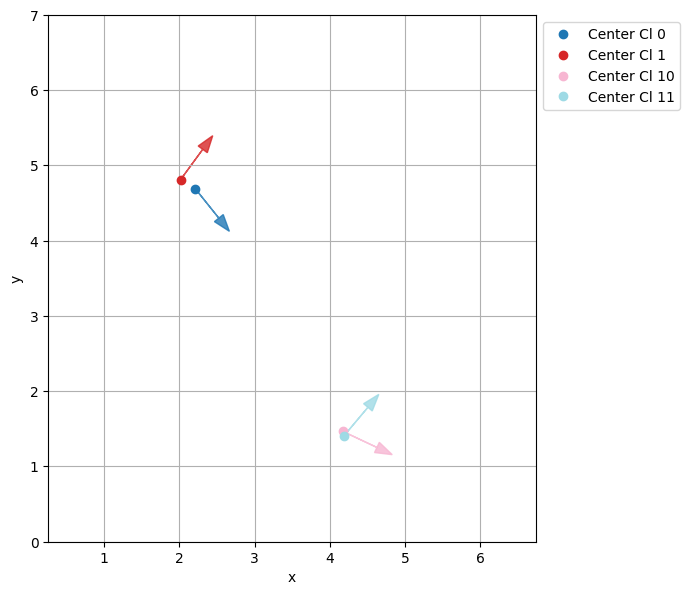

In [26]:
emg_data_session1 = filtered_emg_FD_session1
features_session1 = get_centers_directions(emg_data_session1,gaussian_2d, ptp, 2000,25)
results_df_session1, summary_df_session1 = clustering(features_session1, k1=2, k2=2)
summary_df_session1
plot_fiber(results_df_session1)
virtual_bipolars_session1, labels_session1, center_direction_session1, n_virtual_bipolars_session1 = get_virtual_bipolars(results_df_session1)
virtual_emg_session1 = get_virtual_emg(emg_data_session1, virtual_bipolars_session1)
X_session1, y_session1 = get_features(virtual_emg_session1, labels_session1)

検出されたピーク数（条件を満たすもの）: 609


C:\Users\takeu\AppData\Local\Temp\ipykernel_19204\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


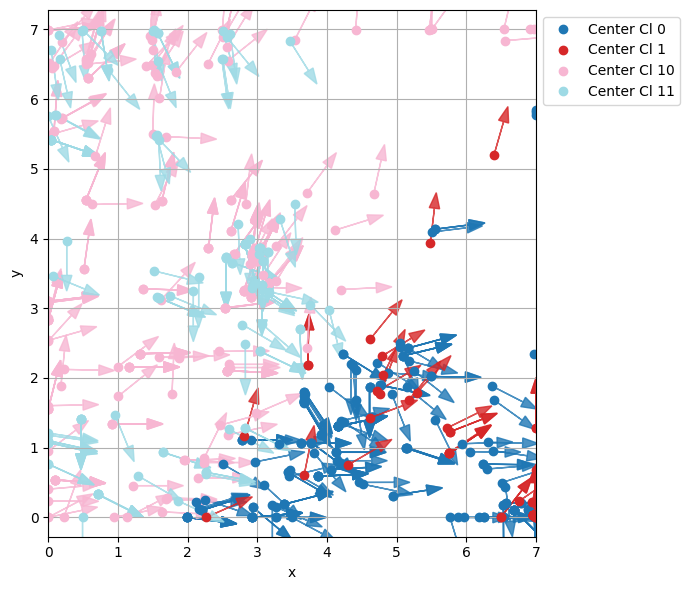

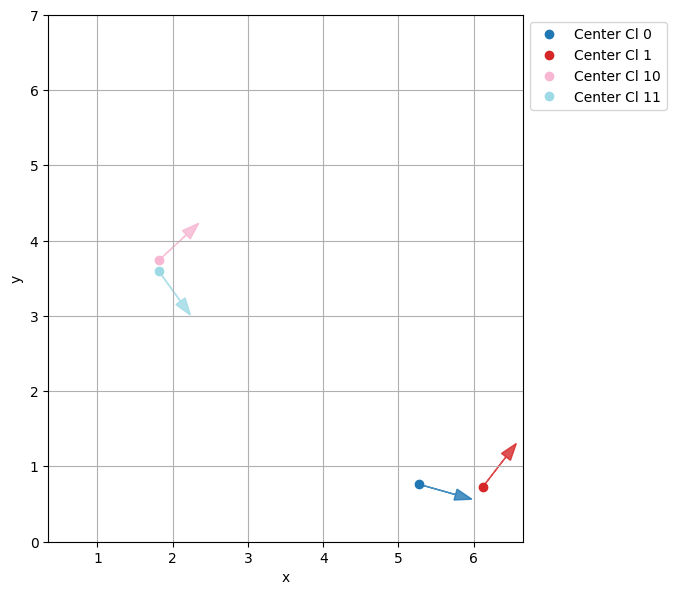

In [23]:
emg_data_session2 = filtered_emg_FD_session2
features_session2 = get_centers_directions(emg_data_session2,gaussian_2d, ptp, 2000,25)
results_df_session2, summary_df_session2 = clustering(features_session2, k1=2, k2=2)
summary_df_session2
plot_fiber(results_df_session2)
virtual_bipolars_session2, labels_session2, center_direction_session2, n_virtual_bipolars_session2 = get_virtual_bipolars(results_df_session2)
virtual_emg_session2 = get_virtual_emg(emg_data_session2, virtual_bipolars_session2)
X_session2, y_session2 = get_features(virtual_emg_session2, labels_session2)

In [159]:
summary_df_session1

,cluster,center_x_mean,center_x_std,center_y_mean,center_y_std,theta_deg_mean,theta_deg_std,count
0,0,2.422315,0.868646,4.354374,1.387342,-8.942075,56.787375,40
1,1,2.449972,0.722740,4.184903,1.175345,-15.458593,83.187139,66
2,2,2.749097,0.937527,4.929814,1.445651,-5.455918,26.997644,48
3,10,5.701628,1.495503,0.686238,0.629430,-31.056992,50.362074,37
4,11,4.643135,1.633042,1.016923,0.688866,-33.522504,76.277764,33
5,12,5.013609,1.739702,0.678575,0.573127,-2.333905,16.904220,71
6,20,6.512788,0.597538,3.501018,0.249069,-10.720938,19.705314,30
7,21,5.335410,0.586528,3.609914,0.421116,-5.005314,68.166472,11
8,22,6.635289,0.416817,3.449483,1.035760,29.476661,80.955168,21
9,30,6.256506,0.615164,6.393637,0.720747,-18.921101,73.968812,23


In [160]:
summary_df_session2

,cluster,center_x_mean,center_x_std,center_y_mean,center_y_std,theta_deg_mean,theta_deg_std,count
0,0,6.019974,0.886804,1.986531,1.116491,-1.226718,22.855913,122
1,1,5.822146,0.749288,2.311047,1.113573,-31.287455,77.673721,42
2,2,6.268530,0.579236,2.044770,1.447048,-0.285111,55.541435,28
3,10,1.788458,0.532265,4.802297,1.061695,16.032749,65.968380,43
4,11,2.397312,0.555297,5.272397,0.926989,-7.157849,27.543675,61
5,12,2.107264,0.583359,4.739549,0.766643,26.620240,83.316075,66
6,20,2.543424,0.913659,1.408311,0.680241,-15.145749,43.456027,28
7,21,2.051515,0.844561,1.541666,1.151428,-1.484318,86.506016,23
8,22,2.526606,0.899992,1.013429,0.995929,-1.903584,13.235124,68
9,30,4.497429,0.924421,6.678763,0.531231,-0.712612,19.402383,49


In [174]:
filtered_emg_ED_session1.shape

(8192, 64)

検出されたピーク数（条件を満たすもの）: 317


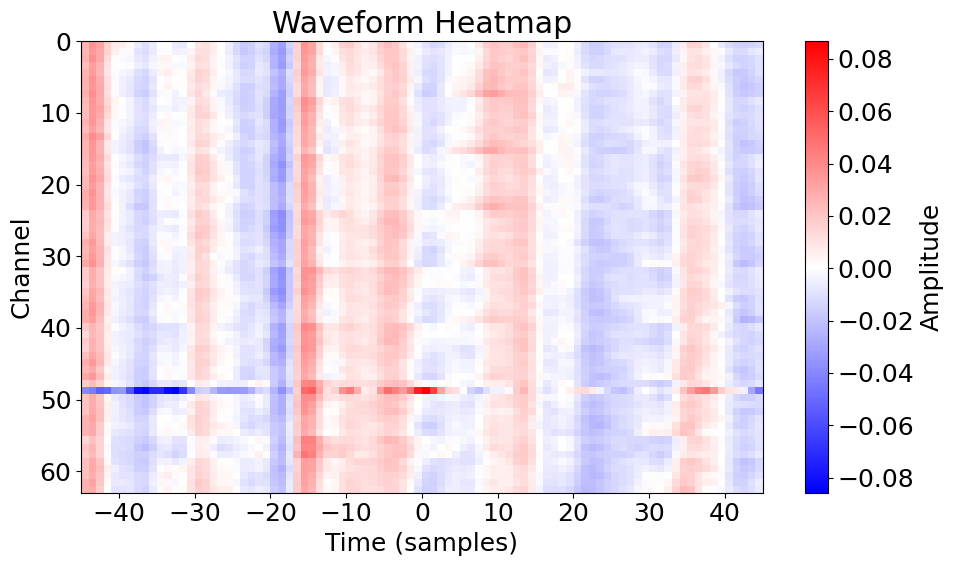

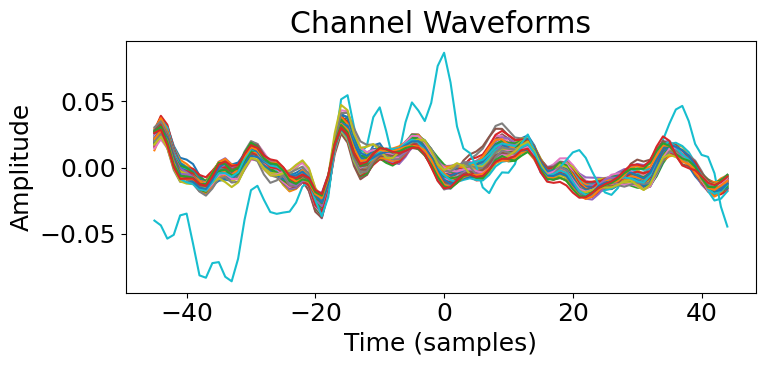

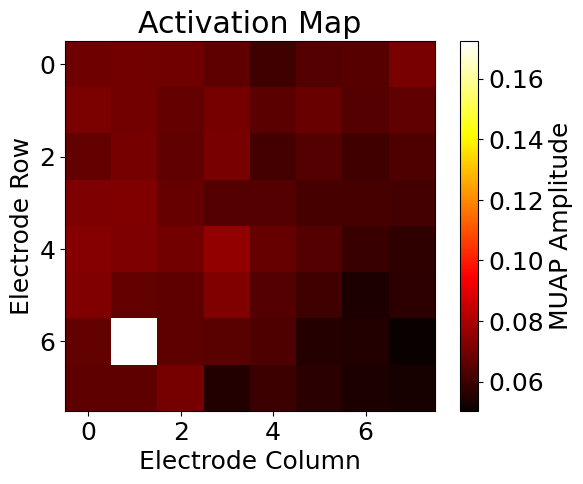

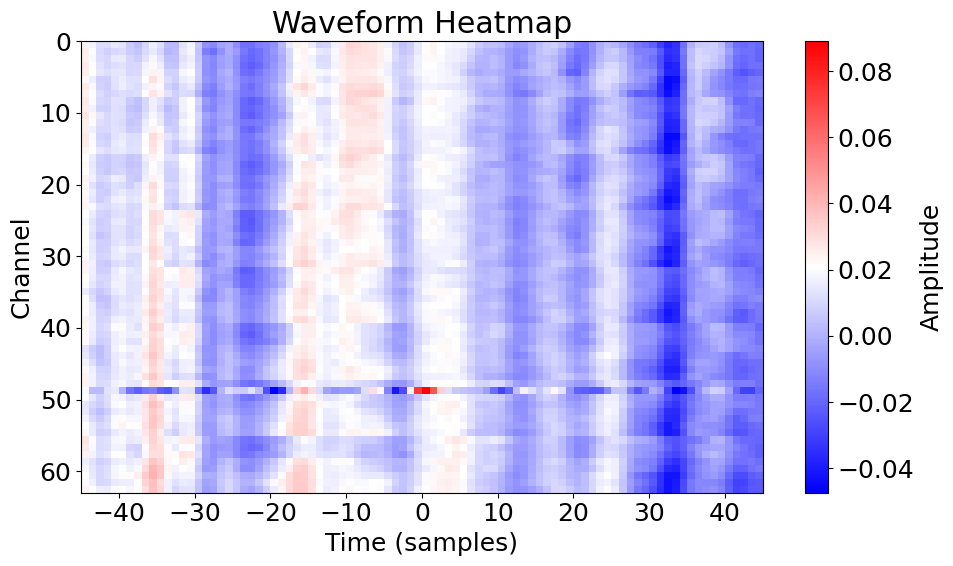

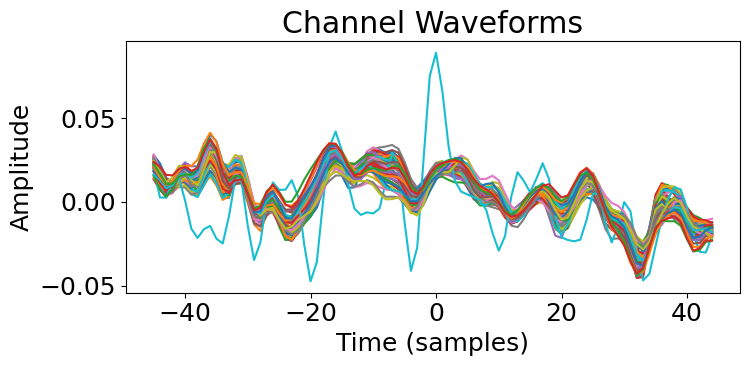

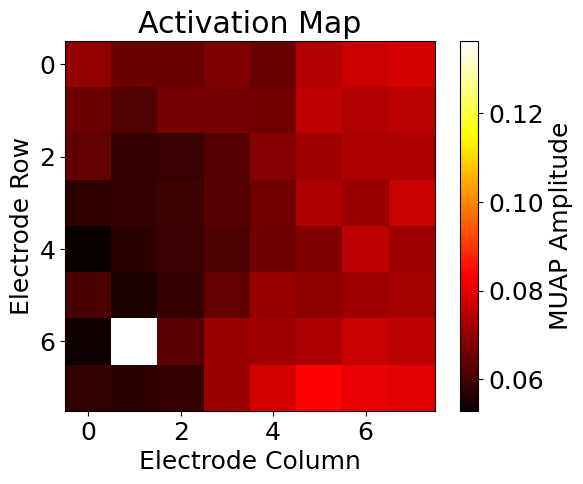

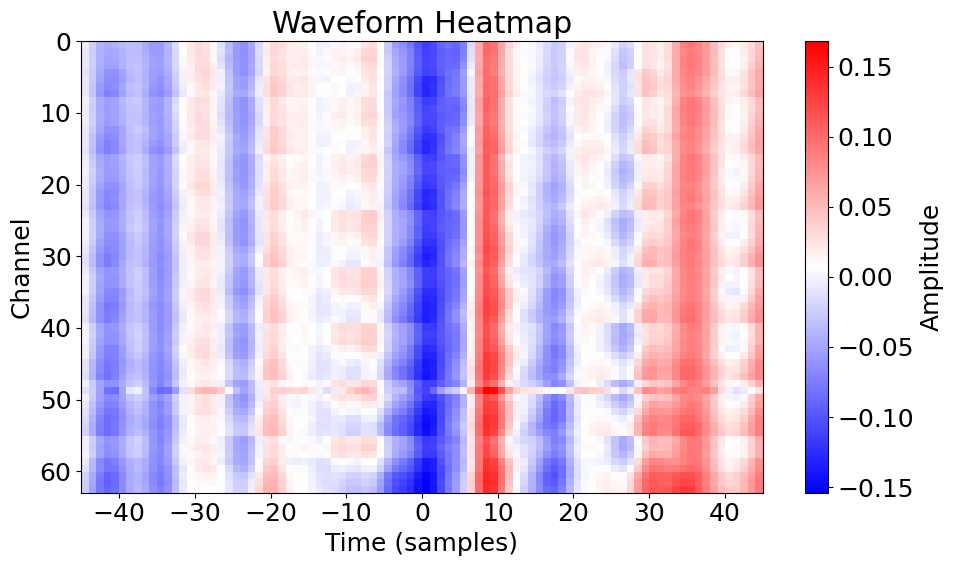

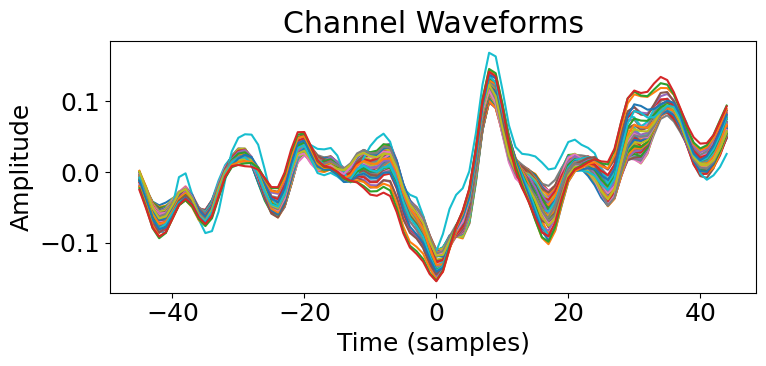

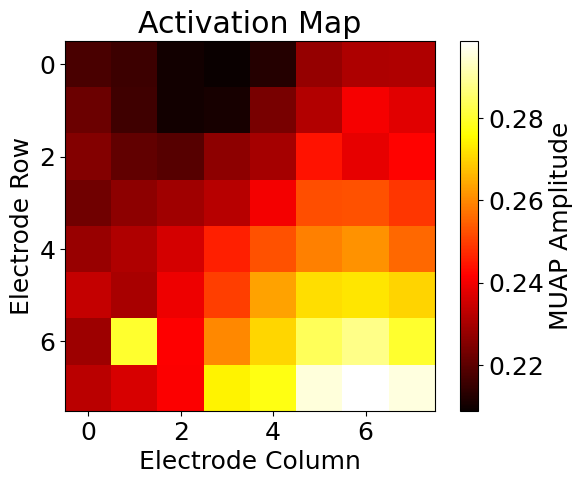

In [177]:
# ---------- パラメータ設定 ----------
window_size = 90  # ウィンドウの長さ（例: 50サンプル）
threshold = 0   # PTPの最大 - 平均がこの値以上なら採用
half_win = window_size // 2

# ---------- EMG信号（例：num_samples × 64） ----------
emg_data = filtered_emg_EP_session1
num_samples = emg_data.shape[0]

# ---------- 出力先 ----------
valid_indices = []

# ---------- 64チャネルすべてに対してピーク検出 ----------
peak_mask = np.zeros(emg_data.shape[0], dtype=bool)

for ch in range(64):
    rms_signal = np.sqrt(emg_data[:,ch]**2)
    peaks, _ = find_peaks(rms_signal, distance=window_size,
                      height=np.mean(rms_signal) + np.std(rms_signal))
    # peaks, _ = find_peaks(emg_data[:, ch], distance=window_size//2, height=np.std(emg_data[:,ch]) * 1)
    peak_mask[peaks] = True  # どこか1チャネルでもピークがあればTrue

# ---------- 全体でのピーク位置で条件を評価 ----------
for t in np.where(peak_mask)[0]:
    if t - half_win < 0 or t + half_win >= num_samples:
        continue  # ウィンドウが境界を超えるならスキップ

    snippet = emg_data[t - half_win : t + half_win, :]  # shape: [window_size, 64]
    ptp_per_ch = snippet.max(axis=0) - snippet.min(axis=0)  # 各チャネルのPTP
    ptp_mean = np.mean(ptp_per_ch)
    ptp_max = np.max(ptp_per_ch)

    if ptp_max - ptp_mean >= threshold:
        valid_indices.append(t)

print(f"検出されたピーク数（条件を満たすもの）: {len(valid_indices)}")

# ----- MUAP波形の切り出し -----
snippets = []
valid_peaks = []
for peak in valid_indices:
    if peak - window_size//2 >= 0 and peak + window_size//2 < emg_data.shape[0]:
        snippet = emg_data[peak - window_size//2 : peak + window_size//2, :]
        snippets.append(snippet)
        valid_peaks.append(peak)

snippets = np.array(snippets)
valid_peaks = np.array(valid_peaks)

for snippet in snippets[:3]:
  # === 波形ヒートマップ ===
  plt.figure(figsize=(10, 6))
  plt.imshow(snippet.T, aspect='auto', cmap='bwr',
              extent=[-window_size//2, window_size//2, 63, 0])
  plt.colorbar(label="Amplitude")
  plt.title(f"Waveform Heatmap")
  plt.xlabel("Time (samples)")
  plt.ylabel("Channel")
  plt.tight_layout()
  plt.show()

  # === チャネル別波形 ===
  plt.figure(figsize=(8, 4))
  for ch in range(snippet.shape[1]):  # 任意チャネル
      plt.plot(np.arange(-window_size//2, window_size//2), snippet[:, ch], label=f'Ch {ch}')
  plt.title(f"Channel Waveforms")
  plt.xlabel("Time (samples)")
  plt.ylabel("Amplitude")
  # plt.legend()
  plt.tight_layout()
  plt.show()

  ptp = np.ptp(snippet,axis=0)
  map_2d = ptp.reshape((8, 8))
  plt.figure()
  plt.imshow(map_2d, cmap='hot', interpolation='nearest')
  plt.colorbar(label='MUAP Amplitude')
  plt.title(f'Activation Map')
  plt.xlabel('Electrode Column')
  plt.ylabel('Electrode Row')
  plt.show()

In [163]:
np.min(features_session1)

-89.99999999999999

In [ ]:
ied = 2
results_df = results_df_session1
#仮想双極電極の電極間距離（cm）
a = ied

n_clusters = results_df['direction_cluster'].nunique()
cluster_colors = get_cluster_colors(n_clusters)

virtual_bipolars = []
labels = []
center_direction = []
for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
  sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
  if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
    x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
    theta = sub_df['theta_deg'].mean()
    dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale
    print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
    x1 = x - a/2*np.cos(np.radians(theta))
    y1 = y - a/2*np.sin(np.radians(theta))
    x2 = x + a/2*np.cos(np.radians(theta))
    y2 = y + a/2*np.sin(np.radians(theta))
    virtual_bipolars.append([x1, y1, x2, y2])
    labels.append(direction_cluster)
    center_direction.append([x, y, theta])
    # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
    color = cluster_colors[n]
    plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
    plt.plot(x, y, 'o', color=color,
              label=f"Center Cl {direction_cluster}" if f"Center Cl {direction_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")
# ラベル・軸
plt.xlabel("center_x")
plt.ylabel("center_y")
plt.title("2-Stage Clustering of Muscle Fiber Direction")
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

print(len(virtual_bipolars))
# return virtual_bipolars, labels, center_direction

In [ ]:
#分類器
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix

X_train = np.array(X_session1).reshape(-1,1)
y_train = np.array(y_session1).reshape(-1,1)
X_test = np.array(X_session2).reshape(-1,1)
y_test = np.array(y_session2).reshape(-1,1)

# データ分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVMモデル学習
model = SVC(kernel='rbf', probability=True, random_state=0)
model.fit(X_train, y_train)

prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
# === 各テストラベルごとに学習クラスへの平均確率を出力 ===
class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

result = []

for test_label in np.unique(y_test):
    idx = y_test.reshape(-1) == test_label
    mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
    result.append([test_label] + list(mean_prob))

# === 表形式で表示 ===
columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
df_result = pd.DataFrame(result, columns=columns)

# import seaborn as sns
# import matplotlib.pyplot as plt

print(df_result)

In [ ]:
max_train_idx = []
for i in range(np.array(result).shape[0]):
j = np.argmax(np.array(result)[i,1:])
max_train_idx.append(j)
# print(max_train_idx)
for k in set(max_train_idx):
if max_train_idx.count(k) >=2:
    idx = max_train_idx == k
    l = np.argmax(np.array(result)[idx, k+1], axis=0)
    max_test_idx = [i for i, j in enumerate(idx) if j == True]
    print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
else:
    print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')

In [343]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

In [ ]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        for k in range(n_trials):
            print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))
            print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

検出されたピーク数（条件を満たすもの）: 558


C:\Users\takeu\AppData\Local\Temp\ipykernel_7044\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


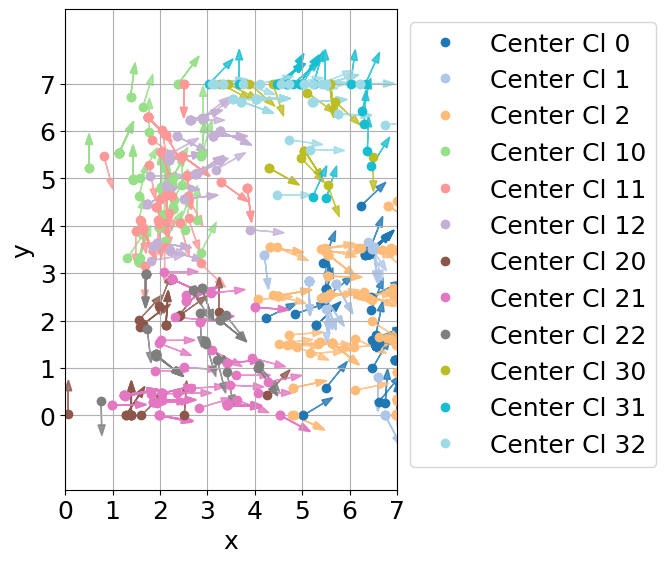

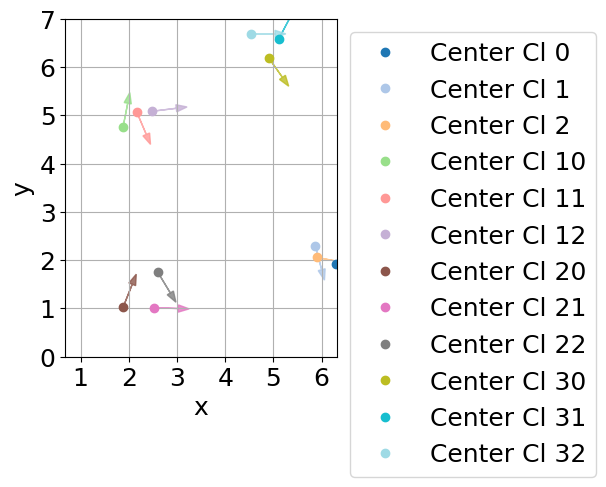

In [84]:
if n_virtual_bipolars_session1 >= 1 and n_virtual_bipolars_session2 >= 1:
    result, y_train, y_test = SVC_classifier(X_session1, y_session1, X_session2, y_session2)
    diff = diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2)
else:
    diff = [None]

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
diff

[{'train': 0, 'test': 0, 'x_diff': 0.0, 'y_diff': 0.0, 'theta_diff': 0.0},
 {'train': 1, 'test': 1, 'x_diff': 0.0, 'y_diff': 0.0, 'theta_diff': 0.0},
 {'train': 10,
  'test': 30,
  'x_diff': -0.7698608525955866,
  'y_diff': -5.9139285467543345,
  'theta_diff': -123.69676232738203},
 {'train': 11,
  'test': 21,
  'x_diff': -1.1627351521386942,
  'y_diff': -3.0324907011129874,
  'theta_diff': 66.76391593118885},
 {'train': 12,
  'test': 2,
  'x_diff': 2.642377943054742,
  'y_diff': -3.879479897623143,
  'theta_diff': 64.97916346947684},
 {'train': 20,
  'test': 22,
  'x_diff': 0.26268270012220274,
  'y_diff': 0.1764151822457225,
  'theta_diff': -88.01811066692053},
 {'train': 30,
  'test': 32,
  'x_diff': 0.6036834505688065,
  'y_diff': 0.04940618051904622,
  'theta_diff': 107.4485991820015},
 {'train': 32,
  'test': 10,
  'x_diff': 0.1661774020267801,
  'y_diff': 5.864522366235288,
  'theta_diff': 16.248163145380524}]

In [321]:
n_virtual_bipolars_session2

0

In [338]:
diffs

[{'diff': [{'train': 0,
    'test': 30,
    'x_diff': 3.8259491881339103,
    'y_diff': 3.593425777750928,
    'theta_diff': 132.32900987559782},
   {'train': 30,
    'test': 10,
    'x_diff': -0.02485568984674824,
    'y_diff': -0.05747863767190342,
    'theta_diff': 9.093665741959128}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_session2/maintenance_preprocess_sample1'],
  'electrode_place': 'ED'},
 {'diff': [{'train': 20,
    'test': 21,
    'x_diff': 3.9834823697861856,
    'y_diff': 2.5134437058997183,
    'theta_diff': -8.075040434084851},
   {'train': 30,
    'test': 31,
    'x_diff': 0.7655725323054208,
    'y_diff': 0.15258456651748098,
    'theta_diff': -6.914685794504898},
   {'train': 32,
    'test': 11,
    'x_diff': 3.10617847342346,
    'y_diff': 1.6273900614522736,
    'theta_diff': 14.760163601038961}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_s